In [1]:
import numpy as np
from numba import jit
import pints
import pints.plot
import pints_smol_jit as toy
import matplotlib.pyplot as plt



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [2]:

model = toy.SmolModel(None,None)


true_parameters = [0.0004, 500]


times = np.linspace(0, 97, 9700)

org_values = model.simulate(true_parameters, times)

print(org_values)

print(org_values.shape)


Init 1
[[5.00000000e+002 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [4.99001395e+002 4.98554253e-001 4.98097899e-004 ... 4.35430388e-286
  4.39782144e-289 4.43609809e-292]
 [4.98005779e+002 9.94125808e-001 1.98447766e-003 ... 1.06595281e-258
  2.14300657e-261 4.30440349e-264]
 ...
 [4.36879537e+000 3.96042606e+000 3.59022903e+000 ... 3.85763559e-004
  3.56964840e-004 3.31154202e-004]
 [4.36797861e+000 3.95972382e+000 3.58962704e+000 ... 3.86061904e-004
  3.57244654e-004 3.31417218e-004]
 [4.36716209e+000 3.95902177e+000 3.58902520e+000 ... 3.86360415e-004
  3.57524627e-004 3.31680386e-004]]
(9700, 100)


Add noise to the data (using random sampling from normal distribution)

In [3]:

noise = 1
# values = org_values + noise * np.random.normal(0, 0.25, org_values.shape))
values = org_values *(1 + noise * np.random.normal(0, 1, org_values.shape))
# values = np.log(org_values) + noise * np.random.normal(0, 1, org_values.shape)
# values = np.exp(values)

# size_noise = 100
# noise_value = 25
# # Create a list with the specified size filled with a placeholder value
# noise_arr = [noise_value for _ in range(size_noise)]


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_97861/2508203899.py:4: RuntimeWarning: divide by zero encountered in log
  values = np.log(org_values) + noise * np.random.normal(0, 1, org_values.shape)


Set-up pints problem and log likelihoods

In [4]:

problem = pints.MultiOutputProblem(model, times, values)


log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood_2.n_parameters()))

# true_parameters += noise_arr
print(true_parameters)



Original problem dimension: 2
New dimension: 2
[0.0004, 500]


Create uniform log prior

In [5]:

# # Define the size of the list
# size = 102
# placeholder_lower_value = 1
# placeholder_upper_value = 50
 
# # Create a list with the specified size filled with a placeholder value
# prior_arr_lower = [placeholder_lower_value for _ in range(size)]
# prior_arr_upper = [placeholder_upper_value for _ in range(size)]
# prior_arr_lower[0] = 0.0001
# prior_arr_upper[0] = 0.001
# prior_arr_lower[1] = 100
# prior_arr_upper[1] = 1000

log_prior = pints.UniformLogPrior(
    [0.000001, 1],
    [0.01, 10000]
    )
# log_prior = pints.UniformLogPrior(
#     prior_arr_lower,
#     prior_arr_upper
#     )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood_2, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_97861/2347410252.py:14: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [6]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

chains = pints.mcmc_sample(log_posterior, 3, xs)

print(chains)



Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.1
1     6      0         0         0          0:00.1
2     9      0         0         0          0:00.2
3     12     0         0         0          0:00.2
20    63     0         0.0476    0          0:00.3
40    123    0.0244    0.0244    0          0:00.6
60    183    0.0164    0.0164    0.0328     0:00.8
80    243    0.0247    0.0123    0.0247     0:01.0
100   303    0.0198    0.0099    0.0297     0:01.2
120   363    0.0165    0.00826   0.0331     0:01.4
140   423    0.0142    0.00709   0.0284     0:01.7
160   483    0.0124    0.00621   0.0248     0:01.9
180   543    0.0166    0.00552   0.0221     0:02.1
Initial phase completed.
200   603    0.0149    0.00498   0.0199     0:02.4
220   663    0.0271    0.0136    0.0181     0:02.7
240   723    0.0373    0.0124    0.0249     0:03.0
260   783   

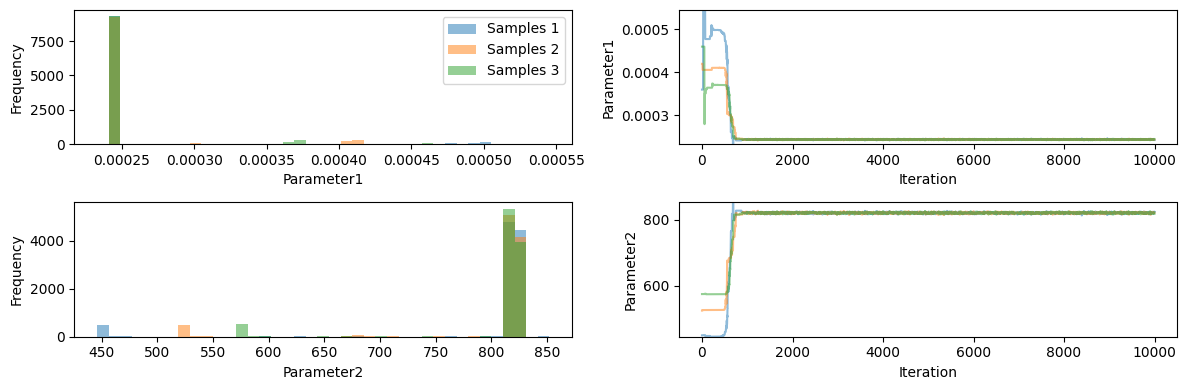

In [7]:

pints.plot.trace(chains)
plt.savefig("mcmc.png")
plt.show()